In [84]:
# Adapted from :  https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html

In [85]:
import numpy as np

print("Expected cross entropy loss if the model:")
print("- learns neither dependency:", -(0.625 * np.log(0.625) +
                                      0.375 * np.log(0.375)))
# Learns first dependency only ==> 0.51916669970720941
print("- learns first dependency:  ",
      -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
      -0.5 * (0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns both dependencies: ", -0.50 * (0.75 * np.log(0.75) + 0.25 * np.log(0.25))
      - 0.25 * (2 * 0.50 * np.log (0.50)) - 0.25 * (0))

Expected cross entropy loss if the model:
- learns neither dependency: 0.661563238158
- learns first dependency:   0.519166699707
- learns both dependencies:  0.454454367449


In [86]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [87]:
# Global config variables
num_steps = 20 # number of truncated backprop steps ('n' in the discussion above)
num_seqs =  10000
batch_size = 200
num_classes = 2
state_size = 1024
learning_rate = 0.25

In [88]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
            
    X = np.reshape(X, [size//num_steps, num_steps])
    Y = np.reshape(Y, [size//num_steps, num_steps])
    return X, Y

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size):
    raw_x, raw_y = raw_data(num_seqs)
    print(raw_x.shape)
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        return (x, y)

def gen_epochs(n):
    for i in range(n):
        return gen_batch(gen_data(), batch_size)
    
    

In [89]:
train_x, train_y = gen_data(num_seqs)
print(train_x.shape, train_y.shape)

(500, 20) (500, 20)


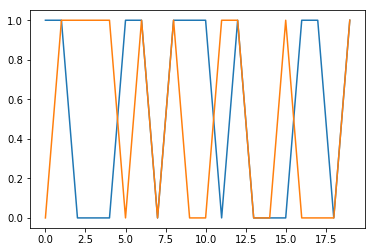

In [90]:
plt.plot(train_x[0])
plt.plot(train_y[0])
plt.show()

In [91]:
tf.reset_default_graph()

"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
Inputs
"""

rnn_inputs = tf.one_hot(x, num_classes)

"""
RNN
"""

cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

print(rnn_outputs.shape) # <n, t, h>
print(final_state.shape) # <n, h>
"""
Predictions, loss, training step
"""

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))

logits = tf.reshape(
            tf.matmul(tf.reshape(rnn_outputs, [-1, state_size]), W) + b,
            [batch_size, num_steps, num_classes]) # <n, t, o>

predictions = tf.nn.softmax(logits)

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
total_loss = tf.reduce_mean(losses)
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

(200, 20, 1024)
(200, 1024)


In [102]:
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size):
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        
        
        num_minibatches = train_x.shape[0] // batch_size
        
        for epoch in range(10000):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            
            print("\nEPOCH", epoch)
            for minibatch_idx in range(num_minibatches):
                
                batch_x = train_x[minibatch_idx * batch_size: (minibatch_idx+1) * batch_size]
                batch_y = train_y[minibatch_idx * batch_size: (minibatch_idx+1) * batch_size]
                
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              optimizer],
                                  feed_dict={x:batch_x, y:batch_y, init_state:training_state})
                training_loss += training_loss_
                
            training_losses.append(training_loss/num_minibatches)     
            print("Average loss at epoch", epoch, ":", training_losses[-1])

    return training_losses


EPOCH 0
Average loss at epoch 0 : 1.15008288622

EPOCH 1
Average loss at epoch 1 : 38.7107095718

EPOCH 2
Average loss at epoch 2 : 77.1519508362

EPOCH 3
Average loss at epoch 3 : 20.4854736328

EPOCH 4
Average loss at epoch 4 : 22.0538473129

EPOCH 5
Average loss at epoch 5 : 34.3794193268

EPOCH 6
Average loss at epoch 6 : 22.845531106

EPOCH 7
Average loss at epoch 7 : 21.7088336945

EPOCH 8
Average loss at epoch 8 : 21.1069784164

EPOCH 9
Average loss at epoch 9 : 17.1721298695

EPOCH 10
Average loss at epoch 10 : 14.8933906555

EPOCH 11
Average loss at epoch 11 : 14.8098826408

EPOCH 12
Average loss at epoch 12 : 17.5819485188

EPOCH 13
Average loss at epoch 13 : 21.0548386574

EPOCH 14
Average loss at epoch 14 : 13.4297277927

EPOCH 15
Average loss at epoch 15 : 11.1147933006

EPOCH 16
Average loss at epoch 16 : 14.7185640335

EPOCH 17
Average loss at epoch 17 : 13.0842037201

EPOCH 18
Average loss at epoch 18 : 12.5295410156

EPOCH 19
Average loss at epoch 19 : 14.3586878777



Average loss at epoch 159 : 4.14555764198

EPOCH 160
Average loss at epoch 160 : 3.63745725155

EPOCH 161
Average loss at epoch 161 : 3.64263880253

EPOCH 162
Average loss at epoch 162 : 4.01820683479

EPOCH 163
Average loss at epoch 163 : 3.82025241852

EPOCH 164
Average loss at epoch 164 : 3.52565467358

EPOCH 165
Average loss at epoch 165 : 3.1541839838

EPOCH 166
Average loss at epoch 166 : 3.2983404398

EPOCH 167
Average loss at epoch 167 : 3.98412084579

EPOCH 168
Average loss at epoch 168 : 3.3501585722

EPOCH 169
Average loss at epoch 169 : 3.61866796017

EPOCH 170
Average loss at epoch 170 : 3.27003931999

EPOCH 171
Average loss at epoch 171 : 2.83177793026

EPOCH 172
Average loss at epoch 172 : 3.52655470371

EPOCH 173
Average loss at epoch 173 : 4.33826029301

EPOCH 174
Average loss at epoch 174 : 4.2499922514

EPOCH 175
Average loss at epoch 175 : 4.00018167496

EPOCH 176
Average loss at epoch 176 : 3.95612096786

EPOCH 177
Average loss at epoch 177 : 3.5645840168

EPOCH 17

Average loss at epoch 315 : 2.73592698574

EPOCH 316
Average loss at epoch 316 : 2.82727336884

EPOCH 317
Average loss at epoch 317 : 2.73210608959

EPOCH 318
Average loss at epoch 318 : 2.76013374329

EPOCH 319
Average loss at epoch 319 : 2.70449614525

EPOCH 320
Average loss at epoch 320 : 2.7236392498

EPOCH 321
Average loss at epoch 321 : 2.69124805927

EPOCH 322
Average loss at epoch 322 : 2.68500053883

EPOCH 323
Average loss at epoch 323 : 2.66381382942

EPOCH 324
Average loss at epoch 324 : 2.64124619961

EPOCH 325
Average loss at epoch 325 : 2.60442602634

EPOCH 326
Average loss at epoch 326 : 2.58106815815

EPOCH 327
Average loss at epoch 327 : 2.56415712833

EPOCH 328
Average loss at epoch 328 : 2.56693673134

EPOCH 329
Average loss at epoch 329 : 2.55847120285

EPOCH 330
Average loss at epoch 330 : 2.50412619114

EPOCH 331
Average loss at epoch 331 : 2.42331123352

EPOCH 332
Average loss at epoch 332 : 2.27906692028

EPOCH 333
Average loss at epoch 333 : 2.30601847172

EPOC

Average loss at epoch 471 : 2.14245176315

EPOCH 472
Average loss at epoch 472 : 1.8895354867

EPOCH 473
Average loss at epoch 473 : 1.7127828598

EPOCH 474
Average loss at epoch 474 : 2.24222457409

EPOCH 475
Average loss at epoch 475 : 2.32552206516

EPOCH 476
Average loss at epoch 476 : 2.02288210392

EPOCH 477
Average loss at epoch 477 : 1.82719856501

EPOCH 478
Average loss at epoch 478 : 1.91279864311

EPOCH 479
Average loss at epoch 479 : 1.69701266289

EPOCH 480
Average loss at epoch 480 : 1.3607814908

EPOCH 481
Average loss at epoch 481 : 1.29057961702

EPOCH 482
Average loss at epoch 482 : 1.25256341696

EPOCH 483
Average loss at epoch 483 : 1.54376673698

EPOCH 484
Average loss at epoch 484 : 1.91277575493

EPOCH 485
Average loss at epoch 485 : 2.2434374094

EPOCH 486
Average loss at epoch 486 : 2.40430188179

EPOCH 487
Average loss at epoch 487 : 2.43256616592

EPOCH 488
Average loss at epoch 488 : 1.98228037357

EPOCH 489
Average loss at epoch 489 : 1.58887147903

EPOCH 4

Average loss at epoch 627 : 1.71114116907

EPOCH 628
Average loss at epoch 628 : 1.46162343025

EPOCH 629
Average loss at epoch 629 : 1.46940171719

EPOCH 630
Average loss at epoch 630 : 2.19670832157

EPOCH 631
Average loss at epoch 631 : 2.22391116619

EPOCH 632
Average loss at epoch 632 : 2.28518354893

EPOCH 633
Average loss at epoch 633 : 1.97756993771

EPOCH 634
Average loss at epoch 634 : 1.76516336203

EPOCH 635
Average loss at epoch 635 : 1.75321173668

EPOCH 636
Average loss at epoch 636 : 1.90859246254

EPOCH 637
Average loss at epoch 637 : 2.02685213089

EPOCH 638
Average loss at epoch 638 : 1.86839663982

EPOCH 639
Average loss at epoch 639 : 1.70257782936

EPOCH 640
Average loss at epoch 640 : 1.65416955948

EPOCH 641
Average loss at epoch 641 : 1.59488773346

EPOCH 642
Average loss at epoch 642 : 1.5603518486

EPOCH 643
Average loss at epoch 643 : 2.35741782188

EPOCH 644
Average loss at epoch 644 : 2.19503748417

EPOCH 645
Average loss at epoch 645 : 1.97887194157

EPOC

Average loss at epoch 783 : 1.7651822567

EPOCH 784
Average loss at epoch 784 : 1.76195544004

EPOCH 785
Average loss at epoch 785 : 1.76266026497

EPOCH 786
Average loss at epoch 786 : 1.75801581144

EPOCH 787
Average loss at epoch 787 : 1.74624615908

EPOCH 788
Average loss at epoch 788 : 1.7305586338

EPOCH 789
Average loss at epoch 789 : 1.71468061209

EPOCH 790
Average loss at epoch 790 : 1.69971638918

EPOCH 791
Average loss at epoch 791 : 1.67489933968

EPOCH 792
Average loss at epoch 792 : 1.65985536575

EPOCH 793
Average loss at epoch 793 : 1.66218006611

EPOCH 794
Average loss at epoch 794 : 1.66860496998

EPOCH 795
Average loss at epoch 795 : 1.6627560854

EPOCH 796
Average loss at epoch 796 : 1.64388626814

EPOCH 797
Average loss at epoch 797 : 1.62948966026

EPOCH 798
Average loss at epoch 798 : 1.63440835476

EPOCH 799
Average loss at epoch 799 : 1.64980435371

EPOCH 800
Average loss at epoch 800 : 1.6596109271

EPOCH 801
Average loss at epoch 801 : 1.65099620819

EPOCH 8

Average loss at epoch 939 : 1.47015345097

EPOCH 940
Average loss at epoch 940 : 1.38270699978

EPOCH 941
Average loss at epoch 941 : 1.32471990585

EPOCH 942
Average loss at epoch 942 : 1.280857265

EPOCH 943
Average loss at epoch 943 : 1.26915609837

EPOCH 944
Average loss at epoch 944 : 1.38241791725

EPOCH 945
Average loss at epoch 945 : 1.84113496542

EPOCH 946
Average loss at epoch 946 : 1.81841230392

EPOCH 947
Average loss at epoch 947 : 1.80049788952

EPOCH 948
Average loss at epoch 948 : 1.80619168282

EPOCH 949
Average loss at epoch 949 : 1.77359342575

EPOCH 950
Average loss at epoch 950 : 1.73307698965

EPOCH 951
Average loss at epoch 951 : 1.70433139801

EPOCH 952
Average loss at epoch 952 : 1.67669945955

EPOCH 953
Average loss at epoch 953 : 1.64212882519

EPOCH 954
Average loss at epoch 954 : 1.5967694521

EPOCH 955
Average loss at epoch 955 : 1.54487925768

EPOCH 956
Average loss at epoch 956 : 1.49797445536

EPOCH 957
Average loss at epoch 957 : 1.46181225777

EPOCH 

Average loss at epoch 1091 : 1.6091119051

EPOCH 1092
Average loss at epoch 1092 : 1.63159322739

EPOCH 1093
Average loss at epoch 1093 : 1.6795784831

EPOCH 1094
Average loss at epoch 1094 : 1.56568109989

EPOCH 1095
Average loss at epoch 1095 : 1.58921766281

EPOCH 1096
Average loss at epoch 1096 : 1.5111746788

EPOCH 1097
Average loss at epoch 1097 : 1.48168796301

EPOCH 1098
Average loss at epoch 1098 : 1.47282510996

EPOCH 1099
Average loss at epoch 1099 : 1.4302508831

EPOCH 1100
Average loss at epoch 1100 : 1.4105130434

EPOCH 1101
Average loss at epoch 1101 : 1.40079313517

EPOCH 1102
Average loss at epoch 1102 : 1.35765951872

EPOCH 1103
Average loss at epoch 1103 : 1.36994552612

EPOCH 1104
Average loss at epoch 1104 : 1.40546923876

EPOCH 1105
Average loss at epoch 1105 : 1.41632091999

EPOCH 1106
Average loss at epoch 1106 : 1.38768160343

EPOCH 1107
Average loss at epoch 1107 : 1.35940051079

EPOCH 1108
Average loss at epoch 1108 : 1.35291516781

EPOCH 1109
Average loss at

Average loss at epoch 1243 : 1.33835810423

EPOCH 1244
Average loss at epoch 1244 : 1.34148705006

EPOCH 1245
Average loss at epoch 1245 : 1.34470331669

EPOCH 1246
Average loss at epoch 1246 : 1.30572104454

EPOCH 1247
Average loss at epoch 1247 : 1.28533232212

EPOCH 1248
Average loss at epoch 1248 : 1.26323324442

EPOCH 1249
Average loss at epoch 1249 : 1.28569614887

EPOCH 1250
Average loss at epoch 1250 : 1.35078507662

EPOCH 1251
Average loss at epoch 1251 : 1.3831294179

EPOCH 1252
Average loss at epoch 1252 : 1.36111778021

EPOCH 1253
Average loss at epoch 1253 : 1.32070201635

EPOCH 1254
Average loss at epoch 1254 : 1.28632998466

EPOCH 1255
Average loss at epoch 1255 : 1.27212172747

EPOCH 1256
Average loss at epoch 1256 : 1.2922104001

EPOCH 1257
Average loss at epoch 1257 : 1.32964491844

EPOCH 1258
Average loss at epoch 1258 : 1.34515100718

EPOCH 1259
Average loss at epoch 1259 : 1.33751511574

EPOCH 1260
Average loss at epoch 1260 : 1.31911087036

EPOCH 1261
Average loss

Average loss at epoch 1394 : 1.248524189

EPOCH 1395
Average loss at epoch 1395 : 1.27290999889

EPOCH 1396
Average loss at epoch 1396 : 1.21569472551

EPOCH 1397
Average loss at epoch 1397 : 1.19830262661

EPOCH 1398
Average loss at epoch 1398 : 1.21857720613

EPOCH 1399
Average loss at epoch 1399 : 1.2434169054

EPOCH 1400
Average loss at epoch 1400 : 1.23732626438

EPOCH 1401
Average loss at epoch 1401 : 1.22307962179

EPOCH 1402
Average loss at epoch 1402 : 1.2163131237

EPOCH 1403
Average loss at epoch 1403 : 1.22377294302

EPOCH 1404
Average loss at epoch 1404 : 1.22427344322

EPOCH 1405
Average loss at epoch 1405 : 1.22274523973

EPOCH 1406
Average loss at epoch 1406 : 1.22308373451

EPOCH 1407
Average loss at epoch 1407 : 1.22409468889

EPOCH 1408
Average loss at epoch 1408 : 1.17661452293

EPOCH 1409
Average loss at epoch 1409 : 1.16394162178

EPOCH 1410
Average loss at epoch 1410 : 1.21487694979

EPOCH 1411
Average loss at epoch 1411 : 1.25809514523

EPOCH 1412
Average loss a

Average loss at epoch 1546 : 1.21136826277

EPOCH 1547
Average loss at epoch 1547 : 1.21552759409

EPOCH 1548
Average loss at epoch 1548 : 1.19470846653

EPOCH 1549
Average loss at epoch 1549 : 1.20384675264

EPOCH 1550
Average loss at epoch 1550 : 1.20820844173

EPOCH 1551
Average loss at epoch 1551 : 1.21497374773

EPOCH 1552
Average loss at epoch 1552 : 1.19931900501

EPOCH 1553
Average loss at epoch 1553 : 1.15349051356

EPOCH 1554
Average loss at epoch 1554 : 1.17054110765

EPOCH 1555
Average loss at epoch 1555 : 1.21880632639

EPOCH 1556
Average loss at epoch 1556 : 1.22123724222

EPOCH 1557
Average loss at epoch 1557 : 1.18969535828

EPOCH 1558
Average loss at epoch 1558 : 1.18441510201

EPOCH 1559
Average loss at epoch 1559 : 1.19321900606

EPOCH 1560
Average loss at epoch 1560 : 1.20278763771

EPOCH 1561
Average loss at epoch 1561 : 1.19865751266

EPOCH 1562
Average loss at epoch 1562 : 1.15506315231

EPOCH 1563
Average loss at epoch 1563 : 1.14498892426

EPOCH 1564
Average lo

Average loss at epoch 1698 : 1.06257110834

EPOCH 1699
Average loss at epoch 1699 : 1.07692009211

EPOCH 1700
Average loss at epoch 1700 : 1.0862467885

EPOCH 1701
Average loss at epoch 1701 : 1.08139920235

EPOCH 1702
Average loss at epoch 1702 : 1.06325432658

EPOCH 1703
Average loss at epoch 1703 : 1.04148760438

EPOCH 1704
Average loss at epoch 1704 : 1.03507632017

EPOCH 1705
Average loss at epoch 1705 : 1.03992515802

EPOCH 1706
Average loss at epoch 1706 : 1.05154296756

EPOCH 1707
Average loss at epoch 1707 : 1.06739458442

EPOCH 1708
Average loss at epoch 1708 : 1.05777531862

EPOCH 1709
Average loss at epoch 1709 : 1.05032718182

EPOCH 1710
Average loss at epoch 1710 : 1.06406039

EPOCH 1711
Average loss at epoch 1711 : 1.05821526051

EPOCH 1712
Average loss at epoch 1712 : 1.04123094678

EPOCH 1713
Average loss at epoch 1713 : 1.05580547452

EPOCH 1714
Average loss at epoch 1714 : 1.0658724308

EPOCH 1715
Average loss at epoch 1715 : 1.05374649167

EPOCH 1716
Average loss at

Average loss at epoch 1850 : 1.21266752481

EPOCH 1851
Average loss at epoch 1851 : 1.21476924419

EPOCH 1852
Average loss at epoch 1852 : 1.21050167084

EPOCH 1853
Average loss at epoch 1853 : 1.20872688293

EPOCH 1854
Average loss at epoch 1854 : 1.21006983519

EPOCH 1855
Average loss at epoch 1855 : 1.21174693108

EPOCH 1856
Average loss at epoch 1856 : 1.20603060722

EPOCH 1857
Average loss at epoch 1857 : 1.20481318235

EPOCH 1858
Average loss at epoch 1858 : 1.20872551203

EPOCH 1859
Average loss at epoch 1859 : 1.20332610607

EPOCH 1860
Average loss at epoch 1860 : 1.20332753658

EPOCH 1861
Average loss at epoch 1861 : 1.20262974501

EPOCH 1862
Average loss at epoch 1862 : 1.2007136941

EPOCH 1863
Average loss at epoch 1863 : 1.19906485081

EPOCH 1864
Average loss at epoch 1864 : 1.19867128134

EPOCH 1865
Average loss at epoch 1865 : 1.19473904371

EPOCH 1866
Average loss at epoch 1866 : 1.20021265745

EPOCH 1867
Average loss at epoch 1867 : 1.21103829145

EPOCH 1868
Average los

Average loss at epoch 2002 : 1.07052800059

EPOCH 2003
Average loss at epoch 2003 : 1.06857669353

EPOCH 2004
Average loss at epoch 2004 : 1.0665474236

EPOCH 2005
Average loss at epoch 2005 : 1.06511390209

EPOCH 2006
Average loss at epoch 2006 : 1.06477817893

EPOCH 2007
Average loss at epoch 2007 : 1.05333161354

EPOCH 2008
Average loss at epoch 2008 : 1.04919436574

EPOCH 2009
Average loss at epoch 2009 : 1.05321341753

EPOCH 2010
Average loss at epoch 2010 : 1.05730441213

EPOCH 2011
Average loss at epoch 2011 : 1.0578815937

EPOCH 2012
Average loss at epoch 2012 : 1.05835285783

EPOCH 2013
Average loss at epoch 2013 : 1.05736029148

EPOCH 2014
Average loss at epoch 2014 : 1.05656602979

EPOCH 2015
Average loss at epoch 2015 : 1.05441713333

EPOCH 2016
Average loss at epoch 2016 : 1.05391126871

EPOCH 2017
Average loss at epoch 2017 : 1.05322912335

EPOCH 2018
Average loss at epoch 2018 : 1.05382934213

EPOCH 2019
Average loss at epoch 2019 : 1.05325713754

EPOCH 2020
Average loss

Average loss at epoch 2154 : 1.00214481354

EPOCH 2155
Average loss at epoch 2155 : 0.997083246708

EPOCH 2156
Average loss at epoch 2156 : 0.990506649017

EPOCH 2157
Average loss at epoch 2157 : 0.988225370646

EPOCH 2158
Average loss at epoch 2158 : 0.991325050592

EPOCH 2159
Average loss at epoch 2159 : 0.998542159796

EPOCH 2160
Average loss at epoch 2160 : 1.00320586562

EPOCH 2161
Average loss at epoch 2161 : 1.00317889452

EPOCH 2162
Average loss at epoch 2162 : 0.999591976404

EPOCH 2163
Average loss at epoch 2163 : 0.995490461588

EPOCH 2164
Average loss at epoch 2164 : 0.990469515324

EPOCH 2165
Average loss at epoch 2165 : 0.986079126596

EPOCH 2166
Average loss at epoch 2166 : 0.983781009912

EPOCH 2167
Average loss at epoch 2167 : 0.985689222813

EPOCH 2168
Average loss at epoch 2168 : 0.990081012249

EPOCH 2169
Average loss at epoch 2169 : 0.994233697653

EPOCH 2170
Average loss at epoch 2170 : 0.995049655437

EPOCH 2171
Average loss at epoch 2171 : 0.993362426758

EPOCH 

Average loss at epoch 2302 : 0.966037720442

EPOCH 2303
Average loss at epoch 2303 : 0.938100010157

EPOCH 2304
Average loss at epoch 2304 : 0.92151093483

EPOCH 2305
Average loss at epoch 2305 : 0.907998234034

EPOCH 2306
Average loss at epoch 2306 : 0.912891626358

EPOCH 2307
Average loss at epoch 2307 : 0.944881439209

EPOCH 2308
Average loss at epoch 2308 : 0.973611176014

EPOCH 2309
Average loss at epoch 2309 : 0.963891088963

EPOCH 2310
Average loss at epoch 2310 : 0.937123477459

EPOCH 2311
Average loss at epoch 2311 : 0.931979119778

EPOCH 2312
Average loss at epoch 2312 : 0.942823112011

EPOCH 2313
Average loss at epoch 2313 : 0.954133778811

EPOCH 2314
Average loss at epoch 2314 : 0.94661283493

EPOCH 2315
Average loss at epoch 2315 : 0.920601546764

EPOCH 2316
Average loss at epoch 2316 : 0.923540651798

EPOCH 2317
Average loss at epoch 2317 : 0.9387190938

EPOCH 2318
Average loss at epoch 2318 : 0.952933311462

EPOCH 2319
Average loss at epoch 2319 : 0.946525245905

EPOCH 2

Average loss at epoch 2454 : 1.05112928152

EPOCH 2455
Average loss at epoch 2455 : 1.06453439593

EPOCH 2456
Average loss at epoch 2456 : 1.06681755185

EPOCH 2457
Average loss at epoch 2457 : 1.00831508636

EPOCH 2458
Average loss at epoch 2458 : 1.03764584661

EPOCH 2459
Average loss at epoch 2459 : 1.07287117839

EPOCH 2460
Average loss at epoch 2460 : 1.05702248216

EPOCH 2461
Average loss at epoch 2461 : 1.06639549136

EPOCH 2462
Average loss at epoch 2462 : 1.05967462063

EPOCH 2463
Average loss at epoch 2463 : 1.04927736521

EPOCH 2464
Average loss at epoch 2464 : 1.04508137703

EPOCH 2465
Average loss at epoch 2465 : 1.04733911157

EPOCH 2466
Average loss at epoch 2466 : 1.05706101656

EPOCH 2467
Average loss at epoch 2467 : 1.04821592569

EPOCH 2468
Average loss at epoch 2468 : 1.04413488507

EPOCH 2469
Average loss at epoch 2469 : 1.04505696893

EPOCH 2470
Average loss at epoch 2470 : 1.04087018967

EPOCH 2471
Average loss at epoch 2471 : 1.0402534306

EPOCH 2472
Average los

Average loss at epoch 2602 : 0.950359344482

EPOCH 2603
Average loss at epoch 2603 : 0.972291827202

EPOCH 2604
Average loss at epoch 2604 : 0.989647448063

EPOCH 2605
Average loss at epoch 2605 : 0.950548261404

EPOCH 2606
Average loss at epoch 2606 : 0.928822726011

EPOCH 2607
Average loss at epoch 2607 : 0.928537458181

EPOCH 2608
Average loss at epoch 2608 : 0.939056932926

EPOCH 2609
Average loss at epoch 2609 : 0.947118341923

EPOCH 2610
Average loss at epoch 2610 : 0.950644463301

EPOCH 2611
Average loss at epoch 2611 : 0.988753080368

EPOCH 2612
Average loss at epoch 2612 : 1.00804901123

EPOCH 2613
Average loss at epoch 2613 : 1.04018622637

EPOCH 2614
Average loss at epoch 2614 : 1.0799638629

EPOCH 2615
Average loss at epoch 2615 : 1.02228358388

EPOCH 2616
Average loss at epoch 2616 : 0.963518291712

EPOCH 2617
Average loss at epoch 2617 : 0.929391741753

EPOCH 2618
Average loss at epoch 2618 : 0.922371566296

EPOCH 2619
Average loss at epoch 2619 : 0.945977568626

EPOCH 26

Average loss at epoch 2750 : 0.934032231569

EPOCH 2751
Average loss at epoch 2751 : 0.921352386475

EPOCH 2752
Average loss at epoch 2752 : 0.923262178898

EPOCH 2753
Average loss at epoch 2753 : 0.907405108213

EPOCH 2754
Average loss at epoch 2754 : 0.908276081085

EPOCH 2755
Average loss at epoch 2755 : 0.930558502674

EPOCH 2756
Average loss at epoch 2756 : 0.939625412226

EPOCH 2757
Average loss at epoch 2757 : 0.935461699963

EPOCH 2758
Average loss at epoch 2758 : 0.916478008032

EPOCH 2759
Average loss at epoch 2759 : 0.915382742882

EPOCH 2760
Average loss at epoch 2760 : 0.926221579313

EPOCH 2761
Average loss at epoch 2761 : 0.932104349136

EPOCH 2762
Average loss at epoch 2762 : 0.915893793106

EPOCH 2763
Average loss at epoch 2763 : 0.914019733667

EPOCH 2764
Average loss at epoch 2764 : 0.925190001726

EPOCH 2765
Average loss at epoch 2765 : 0.931273698807

EPOCH 2766
Average loss at epoch 2766 : 0.909160077572

EPOCH 2767
Average loss at epoch 2767 : 0.90834403038

EPOC

Average loss at epoch 2898 : 0.884893059731

EPOCH 2899
Average loss at epoch 2899 : 0.882831275463

EPOCH 2900
Average loss at epoch 2900 : 0.878985822201

EPOCH 2901
Average loss at epoch 2901 : 0.880978137255

EPOCH 2902
Average loss at epoch 2902 : 0.856656193733

EPOCH 2903
Average loss at epoch 2903 : 0.845496922731

EPOCH 2904
Average loss at epoch 2904 : 0.846318393946

EPOCH 2905
Average loss at epoch 2905 : 0.849284797907

EPOCH 2906
Average loss at epoch 2906 : 0.846531689167

EPOCH 2907
Average loss at epoch 2907 : 0.843487799168

EPOCH 2908
Average loss at epoch 2908 : 0.846637934446

EPOCH 2909
Average loss at epoch 2909 : 0.856802910566

EPOCH 2910
Average loss at epoch 2910 : 0.889595001936

EPOCH 2911
Average loss at epoch 2911 : 0.895882546902

EPOCH 2912
Average loss at epoch 2912 : 0.884976893663

EPOCH 2913
Average loss at epoch 2913 : 0.869172126055

EPOCH 2914
Average loss at epoch 2914 : 0.866343468428

EPOCH 2915
Average loss at epoch 2915 : 0.861811697483

EPO

Average loss at epoch 3046 : 0.918806791306

EPOCH 3047
Average loss at epoch 3047 : 0.924436330795

EPOCH 3048
Average loss at epoch 3048 : 0.938314318657

EPOCH 3049
Average loss at epoch 3049 : 0.923131197691

EPOCH 3050
Average loss at epoch 3050 : 0.913715660572

EPOCH 3051
Average loss at epoch 3051 : 0.913611710072

EPOCH 3052
Average loss at epoch 3052 : 0.913090437651

EPOCH 3053
Average loss at epoch 3053 : 0.908548921347

EPOCH 3054
Average loss at epoch 3054 : 0.905107349157

EPOCH 3055
Average loss at epoch 3055 : 0.899984627962

EPOCH 3056
Average loss at epoch 3056 : 0.899769932032

EPOCH 3057
Average loss at epoch 3057 : 0.933224141598

EPOCH 3058
Average loss at epoch 3058 : 0.917646288872

EPOCH 3059
Average loss at epoch 3059 : 0.884927988052

EPOCH 3060
Average loss at epoch 3060 : 0.876545906067

EPOCH 3061
Average loss at epoch 3061 : 0.875418961048

EPOCH 3062
Average loss at epoch 3062 : 0.888893425465

EPOCH 3063
Average loss at epoch 3063 : 0.888290673494

EPO

Average loss at epoch 3194 : 0.889949858189

EPOCH 3195
Average loss at epoch 3195 : 0.893665790558

EPOCH 3196
Average loss at epoch 3196 : 0.883964151144

EPOCH 3197
Average loss at epoch 3197 : 0.887662649155

EPOCH 3198
Average loss at epoch 3198 : 0.889398008585

EPOCH 3199
Average loss at epoch 3199 : 0.887073367834

EPOCH 3200
Average loss at epoch 3200 : 0.883516967297

EPOCH 3201
Average loss at epoch 3201 : 0.883626937866

EPOCH 3202
Average loss at epoch 3202 : 0.883677482605

EPOCH 3203
Average loss at epoch 3203 : 0.895980328321

EPOCH 3204
Average loss at epoch 3204 : 0.900034278631

EPOCH 3205
Average loss at epoch 3205 : 0.881386637688

EPOCH 3206
Average loss at epoch 3206 : 0.878275543451

EPOCH 3207
Average loss at epoch 3207 : 0.877210587263

EPOCH 3208
Average loss at epoch 3208 : 0.886224329472

EPOCH 3209
Average loss at epoch 3209 : 0.886354595423

EPOCH 3210
Average loss at epoch 3210 : 0.882922321558

EPOCH 3211
Average loss at epoch 3211 : 0.878595650196

EPO

Average loss at epoch 3342 : 0.949155092239

EPOCH 3343
Average loss at epoch 3343 : 0.970818310976

EPOCH 3344
Average loss at epoch 3344 : 0.950589060783

EPOCH 3345
Average loss at epoch 3345 : 0.935586720705

EPOCH 3346
Average loss at epoch 3346 : 0.926261276007

EPOCH 3347
Average loss at epoch 3347 : 0.909890472889

EPOCH 3348
Average loss at epoch 3348 : 0.915101975203

EPOCH 3349
Average loss at epoch 3349 : 0.921669661999

EPOCH 3350
Average loss at epoch 3350 : 0.918423682451

EPOCH 3351
Average loss at epoch 3351 : 0.908615171909

EPOCH 3352
Average loss at epoch 3352 : 0.943717002869

EPOCH 3353
Average loss at epoch 3353 : 0.944353669882

EPOCH 3354
Average loss at epoch 3354 : 0.900696486235

EPOCH 3355
Average loss at epoch 3355 : 0.852902829647

EPOCH 3356
Average loss at epoch 3356 : 0.83728903532

EPOCH 3357
Average loss at epoch 3357 : 0.836662441492

EPOCH 3358
Average loss at epoch 3358 : 0.86000302434

EPOCH 3359
Average loss at epoch 3359 : 0.887038290501

EPOCH

Average loss at epoch 3490 : 0.877378940582

EPOCH 3491
Average loss at epoch 3491 : 0.905002683401

EPOCH 3492
Average loss at epoch 3492 : 0.924407452345

EPOCH 3493
Average loss at epoch 3493 : 0.920519322157

EPOCH 3494
Average loss at epoch 3494 : 0.894050002098

EPOCH 3495
Average loss at epoch 3495 : 0.909992188215

EPOCH 3496
Average loss at epoch 3496 : 0.91179010272

EPOCH 3497
Average loss at epoch 3497 : 0.881395697594

EPOCH 3498
Average loss at epoch 3498 : 0.899777024984

EPOCH 3499
Average loss at epoch 3499 : 0.906124055386

EPOCH 3500
Average loss at epoch 3500 : 0.874447375536

EPOCH 3501
Average loss at epoch 3501 : 0.877929747105

EPOCH 3502
Average loss at epoch 3502 : 0.895795345306

EPOCH 3503
Average loss at epoch 3503 : 0.905605465174

EPOCH 3504
Average loss at epoch 3504 : 0.902173250914

EPOCH 3505
Average loss at epoch 3505 : 0.861788451672

EPOCH 3506
Average loss at epoch 3506 : 0.860472708941

EPOCH 3507
Average loss at epoch 3507 : 0.875120282173

EPOC

Average loss at epoch 3638 : 0.878617286682

EPOCH 3639
Average loss at epoch 3639 : 0.889564394951

EPOCH 3640
Average loss at epoch 3640 : 0.902574270964

EPOCH 3641
Average loss at epoch 3641 : 0.912704616785

EPOCH 3642
Average loss at epoch 3642 : 0.909433782101

EPOCH 3643
Average loss at epoch 3643 : 0.858588069677

EPOCH 3644
Average loss at epoch 3644 : 0.848900973797

EPOCH 3645
Average loss at epoch 3645 : 0.864177912474

EPOCH 3646
Average loss at epoch 3646 : 0.885313153267

EPOCH 3647
Average loss at epoch 3647 : 0.888350695372

EPOCH 3648
Average loss at epoch 3648 : 0.881107062101

EPOCH 3649
Average loss at epoch 3649 : 0.88330745697

EPOCH 3650
Average loss at epoch 3650 : 0.848869860172

EPOCH 3651
Average loss at epoch 3651 : 0.856202334166

EPOCH 3652
Average loss at epoch 3652 : 0.871618688107

EPOCH 3653
Average loss at epoch 3653 : 0.878985643387

EPOCH 3654
Average loss at epoch 3654 : 0.885134071112

EPOCH 3655
Average loss at epoch 3655 : 0.85395154357

EPOCH

Average loss at epoch 3786 : 0.905088335276

EPOCH 3787
Average loss at epoch 3787 : 0.8983694911

EPOCH 3788
Average loss at epoch 3788 : 0.899079293013

EPOCH 3789
Average loss at epoch 3789 : 0.884029090405

EPOCH 3790
Average loss at epoch 3790 : 0.896471232176

EPOCH 3791
Average loss at epoch 3791 : 0.902383327484

EPOCH 3792
Average loss at epoch 3792 : 0.901838332415

EPOCH 3793
Average loss at epoch 3793 : 0.901775419712

EPOCH 3794
Average loss at epoch 3794 : 0.897063016891

EPOCH 3795
Average loss at epoch 3795 : 0.86492022872

EPOCH 3796
Average loss at epoch 3796 : 0.885039240122

EPOCH 3797
Average loss at epoch 3797 : 0.893159687519

EPOCH 3798
Average loss at epoch 3798 : 0.878685235977

EPOCH 3799
Average loss at epoch 3799 : 0.891407161951

EPOCH 3800
Average loss at epoch 3800 : 0.895062416792

EPOCH 3801
Average loss at epoch 3801 : 0.889742672443

EPOCH 3802
Average loss at epoch 3802 : 0.893896460533

EPOCH 3803
Average loss at epoch 3803 : 0.86314406991

EPOCH 3

Average loss at epoch 3934 : 0.916294902563

EPOCH 3935
Average loss at epoch 3935 : 0.918527036905

EPOCH 3936
Average loss at epoch 3936 : 0.920652061701

EPOCH 3937
Average loss at epoch 3937 : 0.918630570173

EPOCH 3938
Average loss at epoch 3938 : 0.910022616386

EPOCH 3939
Average loss at epoch 3939 : 0.905454963446

EPOCH 3940
Average loss at epoch 3940 : 0.906827926636

EPOCH 3941
Average loss at epoch 3941 : 0.901129812002

EPOCH 3942
Average loss at epoch 3942 : 0.897622793913

EPOCH 3943
Average loss at epoch 3943 : 0.902284890413

EPOCH 3944
Average loss at epoch 3944 : 0.901889979839

EPOCH 3945
Average loss at epoch 3945 : 0.891826301813

EPOCH 3946
Average loss at epoch 3946 : 0.893862277269

EPOCH 3947
Average loss at epoch 3947 : 0.907783299685

EPOCH 3948
Average loss at epoch 3948 : 0.90738594532

EPOCH 3949
Average loss at epoch 3949 : 0.881789833307

EPOCH 3950
Average loss at epoch 3950 : 0.875222146511

EPOCH 3951
Average loss at epoch 3951 : 0.890750855207

EPOC

Average loss at epoch 4082 : 0.820926934481

EPOCH 4083
Average loss at epoch 4083 : 0.817455023527

EPOCH 4084
Average loss at epoch 4084 : 0.814954340458

EPOCH 4085
Average loss at epoch 4085 : 0.815659314394

EPOCH 4086
Average loss at epoch 4086 : 0.809988856316

EPOCH 4087
Average loss at epoch 4087 : 0.794354259968

EPOCH 4088
Average loss at epoch 4088 : 0.778745532036

EPOCH 4089
Average loss at epoch 4089 : 0.774500608444

EPOCH 4090
Average loss at epoch 4090 : 0.784049063921

EPOCH 4091
Average loss at epoch 4091 : 0.795447856188

EPOCH 4092
Average loss at epoch 4092 : 0.817146718502

EPOCH 4093
Average loss at epoch 4093 : 0.844673931599

EPOCH 4094
Average loss at epoch 4094 : 0.843046724796

EPOCH 4095
Average loss at epoch 4095 : 0.8302064538

EPOCH 4096
Average loss at epoch 4096 : 0.822319984436

EPOCH 4097
Average loss at epoch 4097 : 0.826067984104

EPOCH 4098
Average loss at epoch 4098 : 0.840771347284

EPOCH 4099
Average loss at epoch 4099 : 0.836387097836

EPOCH

Average loss at epoch 4230 : 0.813646882772

EPOCH 4231
Average loss at epoch 4231 : 0.813703030348

EPOCH 4232
Average loss at epoch 4232 : 0.813160926104

EPOCH 4233
Average loss at epoch 4233 : 0.810893565416

EPOCH 4234
Average loss at epoch 4234 : 0.812507092953

EPOCH 4235
Average loss at epoch 4235 : 0.81619438529

EPOCH 4236
Average loss at epoch 4236 : 0.818013995886

EPOCH 4237
Average loss at epoch 4237 : 0.817006349564

EPOCH 4238
Average loss at epoch 4238 : 0.81305205822

EPOCH 4239
Average loss at epoch 4239 : 0.814301073551

EPOCH 4240
Average loss at epoch 4240 : 0.815131306648

EPOCH 4241
Average loss at epoch 4241 : 0.81887665391

EPOCH 4242
Average loss at epoch 4242 : 0.820771813393

EPOCH 4243
Average loss at epoch 4243 : 0.803590595722

EPOCH 4244
Average loss at epoch 4244 : 0.79710355401

EPOCH 4245
Average loss at epoch 4245 : 0.788364171982

EPOCH 4246
Average loss at epoch 4246 : 0.7983764112

EPOCH 4247
Average loss at epoch 4247 : 0.81014379859

EPOCH 4248

Average loss at epoch 4378 : 0.739502280951

EPOCH 4379
Average loss at epoch 4379 : 0.736503005028

EPOCH 4380
Average loss at epoch 4380 : 0.766271024942

EPOCH 4381
Average loss at epoch 4381 : 0.914911001921

EPOCH 4382
Average loss at epoch 4382 : 0.994581490755

EPOCH 4383
Average loss at epoch 4383 : 0.916405498981

EPOCH 4384
Average loss at epoch 4384 : 0.847148418427

EPOCH 4385
Average loss at epoch 4385 : 0.834329217672

EPOCH 4386
Average loss at epoch 4386 : 0.834944039583

EPOCH 4387
Average loss at epoch 4387 : 0.828481137753

EPOCH 4388
Average loss at epoch 4388 : 0.831075072289

EPOCH 4389
Average loss at epoch 4389 : 0.825260490179

EPOCH 4390
Average loss at epoch 4390 : 0.826352387667

EPOCH 4391
Average loss at epoch 4391 : 0.829758703709

EPOCH 4392
Average loss at epoch 4392 : 0.827521622181

EPOCH 4393
Average loss at epoch 4393 : 0.826472550631

EPOCH 4394
Average loss at epoch 4394 : 0.81670820713

EPOCH 4395
Average loss at epoch 4395 : 0.828530967236

EPOC

Average loss at epoch 4526 : 0.80475050211

EPOCH 4527
Average loss at epoch 4527 : 0.804896056652

EPOCH 4528
Average loss at epoch 4528 : 0.814033806324

EPOCH 4529
Average loss at epoch 4529 : 0.808169573545

EPOCH 4530
Average loss at epoch 4530 : 0.810893774033

EPOCH 4531
Average loss at epoch 4531 : 0.81987375021

EPOCH 4532
Average loss at epoch 4532 : 0.81879016757

EPOCH 4533
Average loss at epoch 4533 : 0.823428630829

EPOCH 4534
Average loss at epoch 4534 : 0.825716793537

EPOCH 4535
Average loss at epoch 4535 : 0.8185146451

EPOCH 4536
Average loss at epoch 4536 : 0.80648586154

EPOCH 4537
Average loss at epoch 4537 : 0.800630897284

EPOCH 4538
Average loss at epoch 4538 : 0.801474183798

EPOCH 4539
Average loss at epoch 4539 : 0.804468214512

EPOCH 4540
Average loss at epoch 4540 : 0.808874130249

EPOCH 4541
Average loss at epoch 4541 : 0.809413850307

EPOCH 4542
Average loss at epoch 4542 : 0.809723734856

EPOCH 4543
Average loss at epoch 4543 : 0.808216333389

EPOCH 454

Average loss at epoch 4674 : 0.823369473219

EPOCH 4675
Average loss at epoch 4675 : 0.81646323204

EPOCH 4676
Average loss at epoch 4676 : 0.80166721344

EPOCH 4677
Average loss at epoch 4677 : 0.788656800985

EPOCH 4678
Average loss at epoch 4678 : 0.770585507154

EPOCH 4679
Average loss at epoch 4679 : 0.773814767599

EPOCH 4680
Average loss at epoch 4680 : 0.768758356571

EPOCH 4681
Average loss at epoch 4681 : 0.791493505239

EPOCH 4682
Average loss at epoch 4682 : 0.797752857208

EPOCH 4683
Average loss at epoch 4683 : 0.801404923201

EPOCH 4684
Average loss at epoch 4684 : 0.781741082668

EPOCH 4685
Average loss at epoch 4685 : 0.760435312986

EPOCH 4686
Average loss at epoch 4686 : 0.739594101906

EPOCH 4687
Average loss at epoch 4687 : 0.72353258729

EPOCH 4688
Average loss at epoch 4688 : 0.717500656843

EPOCH 4689
Average loss at epoch 4689 : 0.755890876055

EPOCH 4690
Average loss at epoch 4690 : 0.883455127478

EPOCH 4691
Average loss at epoch 4691 : 0.920806825161

EPOCH 

Average loss at epoch 4822 : 0.730747878551

EPOCH 4823
Average loss at epoch 4823 : 0.776499480009

EPOCH 4824
Average loss at epoch 4824 : 0.908564329147

EPOCH 4825
Average loss at epoch 4825 : 0.894721120596

EPOCH 4826
Average loss at epoch 4826 : 0.836211204529

EPOCH 4827
Average loss at epoch 4827 : 0.818393617868

EPOCH 4828
Average loss at epoch 4828 : 0.813111841679

EPOCH 4829
Average loss at epoch 4829 : 0.79641264677

EPOCH 4830
Average loss at epoch 4830 : 0.790547430515

EPOCH 4831
Average loss at epoch 4831 : 0.790289491415

EPOCH 4832
Average loss at epoch 4832 : 0.795395821333

EPOCH 4833
Average loss at epoch 4833 : 0.795110672712

EPOCH 4834
Average loss at epoch 4834 : 0.785917341709

EPOCH 4835
Average loss at epoch 4835 : 0.773245841265

EPOCH 4836
Average loss at epoch 4836 : 0.75684005022

EPOCH 4837
Average loss at epoch 4837 : 0.759290277958

EPOCH 4838
Average loss at epoch 4838 : 0.769550800323

EPOCH 4839
Average loss at epoch 4839 : 0.783155113459

EPOCH

Average loss at epoch 4970 : 0.801937937737

EPOCH 4971
Average loss at epoch 4971 : 0.807213902473

EPOCH 4972
Average loss at epoch 4972 : 0.786122053862

EPOCH 4973
Average loss at epoch 4973 : 0.790915340185

EPOCH 4974
Average loss at epoch 4974 : 0.801306277514

EPOCH 4975
Average loss at epoch 4975 : 0.802864670753

EPOCH 4976
Average loss at epoch 4976 : 0.791535705328

EPOCH 4977
Average loss at epoch 4977 : 0.781323105097

EPOCH 4978
Average loss at epoch 4978 : 0.764301002026

EPOCH 4979
Average loss at epoch 4979 : 0.745610833168

EPOCH 4980
Average loss at epoch 4980 : 0.729648649693

EPOCH 4981
Average loss at epoch 4981 : 0.718393146992

EPOCH 4982
Average loss at epoch 4982 : 0.723202914

EPOCH 4983
Average loss at epoch 4983 : 0.80352768302

EPOCH 4984
Average loss at epoch 4984 : 0.896462082863

EPOCH 4985
Average loss at epoch 4985 : 0.869679003954

EPOCH 4986
Average loss at epoch 4986 : 0.820054590702

EPOCH 4987
Average loss at epoch 4987 : 0.812736749649

EPOCH 4

Average loss at epoch 5118 : 0.932567089796

EPOCH 5119
Average loss at epoch 5119 : 0.894956111908

EPOCH 5120
Average loss at epoch 5120 : 0.859332174063

EPOCH 5121
Average loss at epoch 5121 : 0.83264324069

EPOCH 5122
Average loss at epoch 5122 : 0.816433340311

EPOCH 5123
Average loss at epoch 5123 : 0.801927745342

EPOCH 5124
Average loss at epoch 5124 : 0.798875033855

EPOCH 5125
Average loss at epoch 5125 : 0.798199594021

EPOCH 5126
Average loss at epoch 5126 : 0.811284631491

EPOCH 5127
Average loss at epoch 5127 : 0.810556232929

EPOCH 5128
Average loss at epoch 5128 : 0.808978050947

EPOCH 5129
Average loss at epoch 5129 : 0.810183376074

EPOCH 5130
Average loss at epoch 5130 : 0.798436701298

EPOCH 5131
Average loss at epoch 5131 : 0.78765258193

EPOCH 5132
Average loss at epoch 5132 : 0.775920242071

EPOCH 5133
Average loss at epoch 5133 : 0.746878325939

EPOCH 5134
Average loss at epoch 5134 : 0.723385900259

EPOCH 5135
Average loss at epoch 5135 : 0.71144592762

EPOCH 

Average loss at epoch 5266 : 0.803712636232

EPOCH 5267
Average loss at epoch 5267 : 0.865862041712

EPOCH 5268
Average loss at epoch 5268 : 0.837862849236

EPOCH 5269
Average loss at epoch 5269 : 0.809783756733

EPOCH 5270
Average loss at epoch 5270 : 0.808450847864

EPOCH 5271
Average loss at epoch 5271 : 0.793175965548

EPOCH 5272
Average loss at epoch 5272 : 0.775341898203

EPOCH 5273
Average loss at epoch 5273 : 0.757268041372

EPOCH 5274
Average loss at epoch 5274 : 0.744630783796

EPOCH 5275
Average loss at epoch 5275 : 0.73665830493

EPOCH 5276
Average loss at epoch 5276 : 0.73925241828

EPOCH 5277
Average loss at epoch 5277 : 0.739518195391

EPOCH 5278
Average loss at epoch 5278 : 0.729657560587

EPOCH 5279
Average loss at epoch 5279 : 0.719118088484

EPOCH 5280
Average loss at epoch 5280 : 0.726147025824

EPOCH 5281
Average loss at epoch 5281 : 0.813176602125

EPOCH 5282
Average loss at epoch 5282 : 0.911651402712

EPOCH 5283
Average loss at epoch 5283 : 0.87935128808

EPOCH 

Average loss at epoch 5414 : 0.783396333456

EPOCH 5415
Average loss at epoch 5415 : 0.780701249838

EPOCH 5416
Average loss at epoch 5416 : 0.78708204627

EPOCH 5417
Average loss at epoch 5417 : 0.763394504786

EPOCH 5418
Average loss at epoch 5418 : 0.759892165661

EPOCH 5419
Average loss at epoch 5419 : 0.778242260218

EPOCH 5420
Average loss at epoch 5420 : 0.789872050285

EPOCH 5421
Average loss at epoch 5421 : 0.798941999674

EPOCH 5422
Average loss at epoch 5422 : 0.791249930859

EPOCH 5423
Average loss at epoch 5423 : 0.788236290216

EPOCH 5424
Average loss at epoch 5424 : 0.781737595797

EPOCH 5425
Average loss at epoch 5425 : 0.782166868448

EPOCH 5426
Average loss at epoch 5426 : 0.77425968647

EPOCH 5427
Average loss at epoch 5427 : 0.781456291676

EPOCH 5428
Average loss at epoch 5428 : 0.770923435688

EPOCH 5429
Average loss at epoch 5429 : 0.776060014963

EPOCH 5430
Average loss at epoch 5430 : 0.774137586355

EPOCH 5431
Average loss at epoch 5431 : 0.780433684587

EPOCH

Average loss at epoch 5562 : 0.794198930264

EPOCH 5563
Average loss at epoch 5563 : 0.802565932274

EPOCH 5564
Average loss at epoch 5564 : 0.798949152231

EPOCH 5565
Average loss at epoch 5565 : 0.797412782907

EPOCH 5566
Average loss at epoch 5566 : 0.79866617918

EPOCH 5567
Average loss at epoch 5567 : 0.80120241642

EPOCH 5568
Average loss at epoch 5568 : 0.793510019779

EPOCH 5569
Average loss at epoch 5569 : 0.792556852102

EPOCH 5570
Average loss at epoch 5570 : 0.793068230152

EPOCH 5571
Average loss at epoch 5571 : 0.798061162233

EPOCH 5572
Average loss at epoch 5572 : 0.790248095989

EPOCH 5573
Average loss at epoch 5573 : 0.785109579563

EPOCH 5574
Average loss at epoch 5574 : 0.784277647734

EPOCH 5575
Average loss at epoch 5575 : 0.792011618614

EPOCH 5576
Average loss at epoch 5576 : 0.795590996742

EPOCH 5577
Average loss at epoch 5577 : 0.801333338022

EPOCH 5578
Average loss at epoch 5578 : 0.792130172253

EPOCH 5579
Average loss at epoch 5579 : 0.785099595785

EPOCH

Average loss at epoch 5710 : 0.772129148245

EPOCH 5711
Average loss at epoch 5711 : 0.763076454401

EPOCH 5712
Average loss at epoch 5712 : 0.762651085854

EPOCH 5713
Average loss at epoch 5713 : 0.767765194178

EPOCH 5714
Average loss at epoch 5714 : 0.762098580599

EPOCH 5715
Average loss at epoch 5715 : 0.761373519897

EPOCH 5716
Average loss at epoch 5716 : 0.763528615236

EPOCH 5717
Average loss at epoch 5717 : 0.76702696085

EPOCH 5718
Average loss at epoch 5718 : 0.770892590284

EPOCH 5719
Average loss at epoch 5719 : 0.774982243776

EPOCH 5720
Average loss at epoch 5720 : 0.764498561621

EPOCH 5721
Average loss at epoch 5721 : 0.759110838175

EPOCH 5722
Average loss at epoch 5722 : 0.759388267994

EPOCH 5723
Average loss at epoch 5723 : 0.763139694929

EPOCH 5724
Average loss at epoch 5724 : 0.767694890499

EPOCH 5725
Average loss at epoch 5725 : 0.771277666092

EPOCH 5726
Average loss at epoch 5726 : 0.763278752565

EPOCH 5727
Average loss at epoch 5727 : 0.759577035904

EPOC

Average loss at epoch 5857 : 0.776537775993

EPOCH 5858
Average loss at epoch 5858 : 0.775790184736

EPOCH 5859
Average loss at epoch 5859 : 0.779946237803

EPOCH 5860
Average loss at epoch 5860 : 0.786384493113

EPOCH 5861
Average loss at epoch 5861 : 0.788082867861

EPOCH 5862
Average loss at epoch 5862 : 0.790823370218

EPOCH 5863
Average loss at epoch 5863 : 0.796470284462

EPOCH 5864
Average loss at epoch 5864 : 0.792122483253

EPOCH 5865
Average loss at epoch 5865 : 0.798187404871

EPOCH 5866
Average loss at epoch 5866 : 0.798523396254

EPOCH 5867
Average loss at epoch 5867 : 0.805925548077

EPOCH 5868
Average loss at epoch 5868 : 0.801368296146

EPOCH 5869
Average loss at epoch 5869 : 0.786688745022

EPOCH 5870
Average loss at epoch 5870 : 0.781209975481

EPOCH 5871
Average loss at epoch 5871 : 0.78338059783

EPOCH 5872
Average loss at epoch 5872 : 0.786529630423

EPOCH 5873
Average loss at epoch 5873 : 0.781690955162

EPOCH 5874
Average loss at epoch 5874 : 0.794250667095

EPOC

Average loss at epoch 6005 : 0.772943377495

EPOCH 6006
Average loss at epoch 6006 : 0.779700994492

EPOCH 6007
Average loss at epoch 6007 : 0.785755515099

EPOCH 6008
Average loss at epoch 6008 : 0.771789431572

EPOCH 6009
Average loss at epoch 6009 : 0.771936118603

EPOCH 6010
Average loss at epoch 6010 : 0.775590091944

EPOCH 6011
Average loss at epoch 6011 : 0.778889387846

EPOCH 6012
Average loss at epoch 6012 : 0.783347189426

EPOCH 6013
Average loss at epoch 6013 : 0.79202157259

EPOCH 6014
Average loss at epoch 6014 : 0.78416672349

EPOCH 6015
Average loss at epoch 6015 : 0.765299767256

EPOCH 6016
Average loss at epoch 6016 : 0.758831858635

EPOCH 6017
Average loss at epoch 6017 : 0.747881919146

EPOCH 6018
Average loss at epoch 6018 : 0.752551555634

EPOCH 6019
Average loss at epoch 6019 : 0.759987473488

EPOCH 6020
Average loss at epoch 6020 : 0.766936987638

EPOCH 6021
Average loss at epoch 6021 : 0.773018032312

EPOCH 6022
Average loss at epoch 6022 : 0.780510693789

EPOCH

Average loss at epoch 6153 : 0.755887955427

EPOCH 6154
Average loss at epoch 6154 : 0.756604164839

EPOCH 6155
Average loss at epoch 6155 : 0.757852137089

EPOCH 6156
Average loss at epoch 6156 : 0.764225333929

EPOCH 6157
Average loss at epoch 6157 : 0.758165955544

EPOCH 6158
Average loss at epoch 6158 : 0.75943723321

EPOCH 6159
Average loss at epoch 6159 : 0.756435275078

EPOCH 6160
Average loss at epoch 6160 : 0.758520275354

EPOCH 6161
Average loss at epoch 6161 : 0.752029329538

EPOCH 6162
Average loss at epoch 6162 : 0.752400279045

EPOCH 6163
Average loss at epoch 6163 : 0.755019575357

EPOCH 6164
Average loss at epoch 6164 : 0.75907972455

EPOCH 6165
Average loss at epoch 6165 : 0.754129678011

EPOCH 6166
Average loss at epoch 6166 : 0.75825881958

EPOCH 6167
Average loss at epoch 6167 : 0.756442725658

EPOCH 6168
Average loss at epoch 6168 : 0.76030164957

EPOCH 6169
Average loss at epoch 6169 : 0.758329421282

EPOCH 6170
Average loss at epoch 6170 : 0.760104030371

EPOCH 6

Average loss at epoch 6301 : 0.729497939348

EPOCH 6302
Average loss at epoch 6302 : 0.719080865383

EPOCH 6303
Average loss at epoch 6303 : 0.717167466879

EPOCH 6304
Average loss at epoch 6304 : 0.724457889795

EPOCH 6305
Average loss at epoch 6305 : 0.732393443584

EPOCH 6306
Average loss at epoch 6306 : 0.729985415936

EPOCH 6307
Average loss at epoch 6307 : 0.728085041046

EPOCH 6308
Average loss at epoch 6308 : 0.725252240896

EPOCH 6309
Average loss at epoch 6309 : 0.723025888205

EPOCH 6310
Average loss at epoch 6310 : 0.720416158438

EPOCH 6311
Average loss at epoch 6311 : 0.719758033752

EPOCH 6312
Average loss at epoch 6312 : 0.720776885748

EPOCH 6313
Average loss at epoch 6313 : 0.711659252644

EPOCH 6314
Average loss at epoch 6314 : 0.713518619537

EPOCH 6315
Average loss at epoch 6315 : 0.719727814198

EPOCH 6316
Average loss at epoch 6316 : 0.729398846626

EPOCH 6317
Average loss at epoch 6317 : 0.730256646872

EPOCH 6318
Average loss at epoch 6318 : 0.729850202799

EPO

Average loss at epoch 6449 : 0.754035502672

EPOCH 6450
Average loss at epoch 6450 : 0.756300479174

EPOCH 6451
Average loss at epoch 6451 : 0.747064501047

EPOCH 6452
Average loss at epoch 6452 : 0.756443142891

EPOCH 6453
Average loss at epoch 6453 : 0.759604483843

EPOCH 6454
Average loss at epoch 6454 : 0.757147878408

EPOCH 6455
Average loss at epoch 6455 : 0.764797121286

EPOCH 6456
Average loss at epoch 6456 : 0.741663098335

EPOCH 6457
Average loss at epoch 6457 : 0.730214983225

EPOCH 6458
Average loss at epoch 6458 : 0.735507667065

EPOCH 6459
Average loss at epoch 6459 : 0.746531426907

EPOCH 6460
Average loss at epoch 6460 : 0.756049662828

EPOCH 6461
Average loss at epoch 6461 : 0.761402845383

EPOCH 6462
Average loss at epoch 6462 : 0.754435062408

EPOCH 6463
Average loss at epoch 6463 : 0.753094434738

EPOCH 6464
Average loss at epoch 6464 : 0.754617780447

EPOCH 6465
Average loss at epoch 6465 : 0.753436565399

EPOCH 6466
Average loss at epoch 6466 : 0.75537326932

EPOC

Average loss at epoch 6597 : 0.713511705399

EPOCH 6598
Average loss at epoch 6598 : 0.709928333759

EPOCH 6599
Average loss at epoch 6599 : 0.709405213594

EPOCH 6600
Average loss at epoch 6600 : 0.713543236256

EPOCH 6601
Average loss at epoch 6601 : 0.719085007906

EPOCH 6602
Average loss at epoch 6602 : 0.706765174866

EPOCH 6603
Average loss at epoch 6603 : 0.701905041933

EPOCH 6604
Average loss at epoch 6604 : 0.707575529814

EPOCH 6605
Average loss at epoch 6605 : 0.713907718658

EPOCH 6606
Average loss at epoch 6606 : 0.722492665052

EPOCH 6607
Average loss at epoch 6607 : 0.723955303431

EPOCH 6608
Average loss at epoch 6608 : 0.727668851614

EPOCH 6609
Average loss at epoch 6609 : 0.723091006279

EPOCH 6610
Average loss at epoch 6610 : 0.71799916029

EPOCH 6611
Average loss at epoch 6611 : 0.716341793537

EPOCH 6612
Average loss at epoch 6612 : 0.717805415392

EPOCH 6613
Average loss at epoch 6613 : 0.690762251616

EPOCH 6614
Average loss at epoch 6614 : 0.681179195642

EPOC

Average loss at epoch 6745 : 0.684127807617

EPOCH 6746
Average loss at epoch 6746 : 0.728811055422

EPOCH 6747
Average loss at epoch 6747 : 0.793515920639

EPOCH 6748
Average loss at epoch 6748 : 0.796451926231

EPOCH 6749
Average loss at epoch 6749 : 0.778424680233

EPOCH 6750
Average loss at epoch 6750 : 0.774696111679

EPOCH 6751
Average loss at epoch 6751 : 0.763515472412

EPOCH 6752
Average loss at epoch 6752 : 0.76219573617

EPOCH 6753
Average loss at epoch 6753 : 0.751198768616

EPOCH 6754
Average loss at epoch 6754 : 0.736314594746

EPOCH 6755
Average loss at epoch 6755 : 0.731673508883

EPOCH 6756
Average loss at epoch 6756 : 0.729459017515

EPOCH 6757
Average loss at epoch 6757 : 0.735217481852

EPOCH 6758
Average loss at epoch 6758 : 0.73149484396

EPOCH 6759
Average loss at epoch 6759 : 0.726300001144

EPOCH 6760
Average loss at epoch 6760 : 0.71315819025

EPOCH 6761
Average loss at epoch 6761 : 0.698997408152

EPOCH 6762
Average loss at epoch 6762 : 0.689546853304

EPOCH 

Average loss at epoch 6895 : 0.710129052401

EPOCH 6896
Average loss at epoch 6896 : 0.706673920155

EPOCH 6897
Average loss at epoch 6897 : 0.69894516468

EPOCH 6898
Average loss at epoch 6898 : 0.692282676697

EPOCH 6899
Average loss at epoch 6899 : 0.689803898335

EPOCH 6900
Average loss at epoch 6900 : 0.703017652035

EPOCH 6901
Average loss at epoch 6901 : 0.764492750168

EPOCH 6902
Average loss at epoch 6902 : 0.822978794575

EPOCH 6903
Average loss at epoch 6903 : 0.833775758743

EPOCH 6904
Average loss at epoch 6904 : 0.801441460848

EPOCH 6905
Average loss at epoch 6905 : 0.779255449772

EPOCH 6906
Average loss at epoch 6906 : 0.820622473955

EPOCH 6907
Average loss at epoch 6907 : 0.813858300447

EPOCH 6908
Average loss at epoch 6908 : 0.790012091398

EPOCH 6909
Average loss at epoch 6909 : 0.782450973988

EPOCH 6910
Average loss at epoch 6910 : 0.77822598815

EPOCH 6911
Average loss at epoch 6911 : 0.775357425213

EPOCH 6912
Average loss at epoch 6912 : 0.768106758595

EPOCH

Average loss at epoch 7043 : 0.715251356363

EPOCH 7044
Average loss at epoch 7044 : 0.717820107937

EPOCH 7045
Average loss at epoch 7045 : 0.706675320864

EPOCH 7046
Average loss at epoch 7046 : 0.698217123747

EPOCH 7047
Average loss at epoch 7047 : 0.691433131695

EPOCH 7048
Average loss at epoch 7048 : 0.688374072313

EPOCH 7049
Average loss at epoch 7049 : 0.685131251812

EPOCH 7050
Average loss at epoch 7050 : 0.685457259417

EPOCH 7051
Average loss at epoch 7051 : 0.683385103941

EPOCH 7052
Average loss at epoch 7052 : 0.684270262718

EPOCH 7053
Average loss at epoch 7053 : 0.688212424517

EPOCH 7054
Average loss at epoch 7054 : 0.705034166574

EPOCH 7055
Average loss at epoch 7055 : 0.750978142023

EPOCH 7056
Average loss at epoch 7056 : 0.783785909414

EPOCH 7057
Average loss at epoch 7057 : 0.760692000389

EPOCH 7058
Average loss at epoch 7058 : 0.745039075613

EPOCH 7059
Average loss at epoch 7059 : 0.732590824366

EPOCH 7060
Average loss at epoch 7060 : 0.727278888226

EPO

Average loss at epoch 7191 : 0.747044622898

EPOCH 7192
Average loss at epoch 7192 : 0.75056630373

EPOCH 7193
Average loss at epoch 7193 : 0.75127440691

EPOCH 7194
Average loss at epoch 7194 : 0.749508440495

EPOCH 7195
Average loss at epoch 7195 : 0.74585428834

EPOCH 7196
Average loss at epoch 7196 : 0.743056684732

EPOCH 7197
Average loss at epoch 7197 : 0.738300144672

EPOCH 7198
Average loss at epoch 7198 : 0.737955957651

EPOCH 7199
Average loss at epoch 7199 : 0.737596303225

EPOCH 7200
Average loss at epoch 7200 : 0.741967469454

EPOCH 7201
Average loss at epoch 7201 : 0.733418405056

EPOCH 7202
Average loss at epoch 7202 : 0.735519587994

EPOCH 7203
Average loss at epoch 7203 : 0.728200405836

EPOCH 7204
Average loss at epoch 7204 : 0.722582757473

EPOCH 7205
Average loss at epoch 7205 : 0.710234194994

EPOCH 7206
Average loss at epoch 7206 : 0.69929048419

EPOCH 7207
Average loss at epoch 7207 : 0.688785225153

EPOCH 7208
Average loss at epoch 7208 : 0.681202411652

EPOCH 7

Average loss at epoch 7339 : 0.712432205677

EPOCH 7340
Average loss at epoch 7340 : 0.711294531822

EPOCH 7341
Average loss at epoch 7341 : 0.707980453968

EPOCH 7342
Average loss at epoch 7342 : 0.706082195044

EPOCH 7343
Average loss at epoch 7343 : 0.702184826136

EPOCH 7344
Average loss at epoch 7344 : 0.698938906193

EPOCH 7345
Average loss at epoch 7345 : 0.692255616188

EPOCH 7346
Average loss at epoch 7346 : 0.687496453524

EPOCH 7347
Average loss at epoch 7347 : 0.676228672266

EPOCH 7348
Average loss at epoch 7348 : 0.67506763339

EPOCH 7349
Average loss at epoch 7349 : 0.690446466208

EPOCH 7350
Average loss at epoch 7350 : 0.73956361413

EPOCH 7351
Average loss at epoch 7351 : 0.78835016489

EPOCH 7352
Average loss at epoch 7352 : 0.791671216488

EPOCH 7353
Average loss at epoch 7353 : 0.770328760147

EPOCH 7354
Average loss at epoch 7354 : 0.752181529999

EPOCH 7355
Average loss at epoch 7355 : 0.737286686897

EPOCH 7356
Average loss at epoch 7356 : 0.728242844343

EPOCH 

Average loss at epoch 7489 : 0.695457100868

EPOCH 7490
Average loss at epoch 7490 : 0.686257630587

EPOCH 7491
Average loss at epoch 7491 : 0.682889074087

EPOCH 7492
Average loss at epoch 7492 : 0.6771286726

EPOCH 7493
Average loss at epoch 7493 : 0.677338480949

EPOCH 7494
Average loss at epoch 7494 : 0.691690444946

EPOCH 7495
Average loss at epoch 7495 : 0.73960980773

EPOCH 7496
Average loss at epoch 7496 : 0.783940881491

EPOCH 7497
Average loss at epoch 7497 : 0.784215778112

EPOCH 7498
Average loss at epoch 7498 : 0.761808693409

EPOCH 7499
Average loss at epoch 7499 : 0.74220213294

EPOCH 7500
Average loss at epoch 7500 : 0.727848410606

EPOCH 7501
Average loss at epoch 7501 : 0.717847913504

EPOCH 7502
Average loss at epoch 7502 : 0.710376232862

EPOCH 7503
Average loss at epoch 7503 : 0.700677216053

EPOCH 7504
Average loss at epoch 7504 : 0.692983210087

EPOCH 7505
Average loss at epoch 7505 : 0.685049891472

EPOCH 7506
Average loss at epoch 7506 : 0.678465306759

EPOCH 7

Average loss at epoch 7637 : 0.697065323591

EPOCH 7638
Average loss at epoch 7638 : 0.687374144793

EPOCH 7639
Average loss at epoch 7639 : 0.678284585476

EPOCH 7640
Average loss at epoch 7640 : 0.670567423105

EPOCH 7641
Average loss at epoch 7641 : 0.666518121958

EPOCH 7642
Average loss at epoch 7642 : 0.680401802063

EPOCH 7643
Average loss at epoch 7643 : 0.715051025152

EPOCH 7644
Average loss at epoch 7644 : 0.746918976307

EPOCH 7645
Average loss at epoch 7645 : 0.740403413773

EPOCH 7646
Average loss at epoch 7646 : 0.717057198286

EPOCH 7647
Average loss at epoch 7647 : 0.704545050859

EPOCH 7648
Average loss at epoch 7648 : 0.699443459511

EPOCH 7649
Average loss at epoch 7649 : 0.697355359793

EPOCH 7650
Average loss at epoch 7650 : 0.694344967604

EPOCH 7651
Average loss at epoch 7651 : 0.692403554916

EPOCH 7652
Average loss at epoch 7652 : 0.688938468695

EPOCH 7653
Average loss at epoch 7653 : 0.686954021454

EPOCH 7654
Average loss at epoch 7654 : 0.68373760581

EPOC

Average loss at epoch 7785 : 0.750846505165

EPOCH 7786
Average loss at epoch 7786 : 0.729615449905

EPOCH 7787
Average loss at epoch 7787 : 0.711150169373

EPOCH 7788
Average loss at epoch 7788 : 0.704395055771

EPOCH 7789
Average loss at epoch 7789 : 0.699297934771

EPOCH 7790
Average loss at epoch 7790 : 0.695573121309

EPOCH 7791
Average loss at epoch 7791 : 0.690659224987

EPOCH 7792
Average loss at epoch 7792 : 0.687011033297

EPOCH 7793
Average loss at epoch 7793 : 0.6805100739

EPOCH 7794
Average loss at epoch 7794 : 0.676812410355

EPOCH 7795
Average loss at epoch 7795 : 0.671130239964

EPOCH 7796
Average loss at epoch 7796 : 0.668712317944

EPOCH 7797
Average loss at epoch 7797 : 0.66615280509

EPOCH 7798
Average loss at epoch 7798 : 0.676902830601

EPOCH 7799
Average loss at epoch 7799 : 0.70946007967

EPOCH 7800
Average loss at epoch 7800 : 0.759941458702

EPOCH 7801
Average loss at epoch 7801 : 0.764182776213

EPOCH 7802
Average loss at epoch 7802 : 0.743833839893

EPOCH 7

Average loss at epoch 7933 : 0.757541835308

EPOCH 7934
Average loss at epoch 7934 : 0.766098707914

EPOCH 7935
Average loss at epoch 7935 : 0.738198637962

EPOCH 7936
Average loss at epoch 7936 : 0.715630382299

EPOCH 7937
Average loss at epoch 7937 : 0.698470979929

EPOCH 7938
Average loss at epoch 7938 : 0.690479516983

EPOCH 7939
Average loss at epoch 7939 : 0.680293768644

EPOCH 7940
Average loss at epoch 7940 : 0.67576277256

EPOCH 7941
Average loss at epoch 7941 : 0.67127379775

EPOCH 7942
Average loss at epoch 7942 : 0.681116789579

EPOCH 7943
Average loss at epoch 7943 : 0.71122699976

EPOCH 7944
Average loss at epoch 7944 : 0.739337235689

EPOCH 7945
Average loss at epoch 7945 : 0.734555125237

EPOCH 7946
Average loss at epoch 7946 : 0.715116351843

EPOCH 7947
Average loss at epoch 7947 : 0.70055937767

EPOCH 7948
Average loss at epoch 7948 : 0.695466220379

EPOCH 7949
Average loss at epoch 7949 : 0.670808494091

EPOCH 7950
Average loss at epoch 7950 : 0.666351854801

EPOCH 7

Average loss at epoch 8081 : 0.679478615522

EPOCH 8082
Average loss at epoch 8082 : 0.668400406837

EPOCH 8083
Average loss at epoch 8083 : 0.662397742271

EPOCH 8084
Average loss at epoch 8084 : 0.656046956778

EPOCH 8085
Average loss at epoch 8085 : 0.65468108654

EPOCH 8086
Average loss at epoch 8086 : 0.662247866392

EPOCH 8087
Average loss at epoch 8087 : 0.695778340101

EPOCH 8088
Average loss at epoch 8088 : 0.746128112078

EPOCH 8089
Average loss at epoch 8089 : 0.757024556398

EPOCH 8090
Average loss at epoch 8090 : 0.73741042614

EPOCH 8091
Average loss at epoch 8091 : 0.717099070549

EPOCH 8092
Average loss at epoch 8092 : 0.697338908911

EPOCH 8093
Average loss at epoch 8093 : 0.69022116065

EPOCH 8094
Average loss at epoch 8094 : 0.678353369236

EPOCH 8095
Average loss at epoch 8095 : 0.671224325895

EPOCH 8096
Average loss at epoch 8096 : 0.666852176189

EPOCH 8097
Average loss at epoch 8097 : 0.678741544485

EPOCH 8098
Average loss at epoch 8098 : 0.714019209146

EPOCH 

Average loss at epoch 8229 : 0.680879354477

EPOCH 8230
Average loss at epoch 8230 : 0.715274006128

EPOCH 8231
Average loss at epoch 8231 : 0.734537065029

EPOCH 8232
Average loss at epoch 8232 : 0.721488118172

EPOCH 8233
Average loss at epoch 8233 : 0.702126652002

EPOCH 8234
Average loss at epoch 8234 : 0.685481697321

EPOCH 8235
Average loss at epoch 8235 : 0.6757619977

EPOCH 8236
Average loss at epoch 8236 : 0.666240602732

EPOCH 8237
Average loss at epoch 8237 : 0.660169094801

EPOCH 8238
Average loss at epoch 8238 : 0.654358923435

EPOCH 8239
Average loss at epoch 8239 : 0.652145922184

EPOCH 8240
Average loss at epoch 8240 : 0.65694385767

EPOCH 8241
Average loss at epoch 8241 : 0.683344364166

EPOCH 8242
Average loss at epoch 8242 : 0.729293525219

EPOCH 8243
Average loss at epoch 8243 : 0.747766762972

EPOCH 8244
Average loss at epoch 8244 : 0.732786923647

EPOCH 8245
Average loss at epoch 8245 : 0.713934034109

EPOCH 8246
Average loss at epoch 8246 : 0.695899009705

EPOCH 

Average loss at epoch 8377 : 0.702443778515

EPOCH 8378
Average loss at epoch 8378 : 0.69243863225

EPOCH 8379
Average loss at epoch 8379 : 0.680100739002

EPOCH 8380
Average loss at epoch 8380 : 0.671570032835

EPOCH 8381
Average loss at epoch 8381 : 0.664375007153

EPOCH 8382
Average loss at epoch 8382 : 0.666178375483

EPOCH 8383
Average loss at epoch 8383 : 0.686974734068

EPOCH 8384
Average loss at epoch 8384 : 0.72192516923

EPOCH 8385
Average loss at epoch 8385 : 0.732480406761

EPOCH 8386
Average loss at epoch 8386 : 0.71477496624

EPOCH 8387
Average loss at epoch 8387 : 0.693352639675

EPOCH 8388
Average loss at epoch 8388 : 0.680566102266

EPOCH 8389
Average loss at epoch 8389 : 0.668922573328

EPOCH 8390
Average loss at epoch 8390 : 0.661663740873

EPOCH 8391
Average loss at epoch 8391 : 0.654793590307

EPOCH 8392
Average loss at epoch 8392 : 0.650482654572

EPOCH 8393
Average loss at epoch 8393 : 0.649683564901

EPOCH 8394
Average loss at epoch 8394 : 0.662183254957

EPOCH 

Average loss at epoch 8525 : 0.73449742794

EPOCH 8526
Average loss at epoch 8526 : 0.72546339035

EPOCH 8527
Average loss at epoch 8527 : 0.705433994532

EPOCH 8528
Average loss at epoch 8528 : 0.69071868062

EPOCH 8529
Average loss at epoch 8529 : 0.677989453077

EPOCH 8530
Average loss at epoch 8530 : 0.67049241066

EPOCH 8531
Average loss at epoch 8531 : 0.663084030151

EPOCH 8532
Average loss at epoch 8532 : 0.664033919573

EPOCH 8533
Average loss at epoch 8533 : 0.67887878418

EPOCH 8534
Average loss at epoch 8534 : 0.713597208261

EPOCH 8535
Average loss at epoch 8535 : 0.731496959925

EPOCH 8536
Average loss at epoch 8536 : 0.718143582344

EPOCH 8537
Average loss at epoch 8537 : 0.69662797451

EPOCH 8538
Average loss at epoch 8538 : 0.682228803635

EPOCH 8539
Average loss at epoch 8539 : 0.669869333506

EPOCH 8540
Average loss at epoch 8540 : 0.662719041109

EPOCH 8541
Average loss at epoch 8541 : 0.654627650976

EPOCH 8542
Average loss at epoch 8542 : 0.651220977306

EPOCH 854

Average loss at epoch 8673 : 0.667544275522

EPOCH 8674
Average loss at epoch 8674 : 0.660684108734

EPOCH 8675
Average loss at epoch 8675 : 0.656760156155

EPOCH 8676
Average loss at epoch 8676 : 0.663168102503

EPOCH 8677
Average loss at epoch 8677 : 0.686909139156

EPOCH 8678
Average loss at epoch 8678 : 0.719417780638

EPOCH 8679
Average loss at epoch 8679 : 0.723061919212

EPOCH 8680
Average loss at epoch 8680 : 0.705435693264

EPOCH 8681
Average loss at epoch 8681 : 0.686783254147

EPOCH 8682
Average loss at epoch 8682 : 0.674535244703

EPOCH 8683
Average loss at epoch 8683 : 0.663116723299

EPOCH 8684
Average loss at epoch 8684 : 0.65547645092

EPOCH 8685
Average loss at epoch 8685 : 0.649884432554

EPOCH 8686
Average loss at epoch 8686 : 0.651631295681

EPOCH 8687
Average loss at epoch 8687 : 0.669365525246

EPOCH 8688
Average loss at epoch 8688 : 0.706358015537

EPOCH 8689
Average loss at epoch 8689 : 0.72892665863

EPOCH 8690
Average loss at epoch 8690 : 0.720721691847

EPOCH

Average loss at epoch 8821 : 0.6775778234

EPOCH 8822
Average loss at epoch 8822 : 0.664955228567

EPOCH 8823
Average loss at epoch 8823 : 0.657239109278

EPOCH 8824
Average loss at epoch 8824 : 0.655612319708

EPOCH 8825
Average loss at epoch 8825 : 0.669956386089

EPOCH 8826
Average loss at epoch 8826 : 0.704045236111

EPOCH 8827
Average loss at epoch 8827 : 0.728645205498

EPOCH 8828
Average loss at epoch 8828 : 0.720987647772

EPOCH 8829
Average loss at epoch 8829 : 0.704083412886

EPOCH 8830
Average loss at epoch 8830 : 0.689435064793

EPOCH 8831
Average loss at epoch 8831 : 0.682978659868

EPOCH 8832
Average loss at epoch 8832 : 0.678580790758

EPOCH 8833
Average loss at epoch 8833 : 0.675871551037

EPOCH 8834
Average loss at epoch 8834 : 0.670385211706

EPOCH 8835
Average loss at epoch 8835 : 0.666976124048

EPOCH 8836
Average loss at epoch 8836 : 0.662932664156

EPOCH 8837
Average loss at epoch 8837 : 0.665544658899

EPOCH 8838
Average loss at epoch 8838 : 0.678432047367

EPOCH

Average loss at epoch 8969 : 0.665484905243

EPOCH 8970
Average loss at epoch 8970 : 0.666087210178

EPOCH 8971
Average loss at epoch 8971 : 0.668977200985

EPOCH 8972
Average loss at epoch 8972 : 0.67602583766

EPOCH 8973
Average loss at epoch 8973 : 0.696888178587

EPOCH 8974
Average loss at epoch 8974 : 0.718191802502

EPOCH 8975
Average loss at epoch 8975 : 0.722306162119

EPOCH 8976
Average loss at epoch 8976 : 0.709458470345

EPOCH 8977
Average loss at epoch 8977 : 0.692027419806

EPOCH 8978
Average loss at epoch 8978 : 0.674506425858

EPOCH 8979
Average loss at epoch 8979 : 0.660565167665

EPOCH 8980
Average loss at epoch 8980 : 0.648797810078

EPOCH 8981
Average loss at epoch 8981 : 0.645811110735

EPOCH 8982
Average loss at epoch 8982 : 0.658155620098

EPOCH 8983
Average loss at epoch 8983 : 0.688345432281

EPOCH 8984
Average loss at epoch 8984 : 0.703499406576

EPOCH 8985
Average loss at epoch 8985 : 0.694779574871

EPOCH 8986
Average loss at epoch 8986 : 0.680605769157

EPOC

Average loss at epoch 9117 : 0.716392666101

EPOCH 9118
Average loss at epoch 9118 : 0.715127885342

EPOCH 9119
Average loss at epoch 9119 : 0.69785451889

EPOCH 9120
Average loss at epoch 9120 : 0.681327670813

EPOCH 9121
Average loss at epoch 9121 : 0.667885959148

EPOCH 9122
Average loss at epoch 9122 : 0.659638315439

EPOCH 9123
Average loss at epoch 9123 : 0.655535399914

EPOCH 9124
Average loss at epoch 9124 : 0.660898000002

EPOCH 9125
Average loss at epoch 9125 : 0.678998321295

EPOCH 9126
Average loss at epoch 9126 : 0.700729995966

EPOCH 9127
Average loss at epoch 9127 : 0.705938607454

EPOCH 9128
Average loss at epoch 9128 : 0.695331513882

EPOCH 9129
Average loss at epoch 9129 : 0.681510150433

EPOCH 9130
Average loss at epoch 9130 : 0.671102881432

EPOCH 9131
Average loss at epoch 9131 : 0.661065787077

EPOCH 9132
Average loss at epoch 9132 : 0.654539972544

EPOCH 9133
Average loss at epoch 9133 : 0.648705720901

EPOCH 9134
Average loss at epoch 9134 : 0.647197842598

EPOC

Average loss at epoch 9265 : 0.692782819271

EPOCH 9266
Average loss at epoch 9266 : 0.677831381559

EPOCH 9267
Average loss at epoch 9267 : 0.664342433214

EPOCH 9268
Average loss at epoch 9268 : 0.65633764863

EPOCH 9269
Average loss at epoch 9269 : 0.651879757643

EPOCH 9270
Average loss at epoch 9270 : 0.655510693789

EPOCH 9271
Average loss at epoch 9271 : 0.668257504702

EPOCH 9272
Average loss at epoch 9272 : 0.68448972702

EPOCH 9273
Average loss at epoch 9273 : 0.691767662764

EPOCH 9274
Average loss at epoch 9274 : 0.688196063042

EPOCH 9275
Average loss at epoch 9275 : 0.679306983948

EPOCH 9276
Average loss at epoch 9276 : 0.671148538589

EPOCH 9277
Average loss at epoch 9277 : 0.662395566702

EPOCH 9278
Average loss at epoch 9278 : 0.656278520823

EPOCH 9279
Average loss at epoch 9279 : 0.650169432163

EPOCH 9280
Average loss at epoch 9280 : 0.647063434124

EPOCH 9281
Average loss at epoch 9281 : 0.647131800652

EPOCH 9282
Average loss at epoch 9282 : 0.655701994896

EPOCH

Average loss at epoch 9413 : 0.692873805761

EPOCH 9414
Average loss at epoch 9414 : 0.690485060215

EPOCH 9415
Average loss at epoch 9415 : 0.676191717386

EPOCH 9416
Average loss at epoch 9416 : 0.662443637848

EPOCH 9417
Average loss at epoch 9417 : 0.651688098907

EPOCH 9418
Average loss at epoch 9418 : 0.648369759321

EPOCH 9419
Average loss at epoch 9419 : 0.64875844121

EPOCH 9420
Average loss at epoch 9420 : 0.653446644545

EPOCH 9421
Average loss at epoch 9421 : 0.660714000463

EPOCH 9422
Average loss at epoch 9422 : 0.66805267334

EPOCH 9423
Average loss at epoch 9423 : 0.672325342894

EPOCH 9424
Average loss at epoch 9424 : 0.673258453608

EPOCH 9425
Average loss at epoch 9425 : 0.669520497322

EPOCH 9426
Average loss at epoch 9426 : 0.664839118719

EPOCH 9427
Average loss at epoch 9427 : 0.657676249743

EPOCH 9428
Average loss at epoch 9428 : 0.65257075429

EPOCH 9429
Average loss at epoch 9429 : 0.648210078478

EPOCH 9430
Average loss at epoch 9430 : 0.647906243801

EPOCH 

Average loss at epoch 9561 : 0.645110338926

EPOCH 9562
Average loss at epoch 9562 : 0.641960591078

EPOCH 9563
Average loss at epoch 9563 : 0.640397399664

EPOCH 9564
Average loss at epoch 9564 : 0.640282332897

EPOCH 9565
Average loss at epoch 9565 : 0.649681448936

EPOCH 9566
Average loss at epoch 9566 : 0.665510445833

EPOCH 9567
Average loss at epoch 9567 : 0.680629134178

EPOCH 9568
Average loss at epoch 9568 : 0.685864746571

EPOCH 9569
Average loss at epoch 9569 : 0.687864929438

EPOCH 9570
Average loss at epoch 9570 : 0.691572844982

EPOCH 9571
Average loss at epoch 9571 : 0.693412423134

EPOCH 9572
Average loss at epoch 9572 : 0.690386772156

EPOCH 9573
Average loss at epoch 9573 : 0.683055430651

EPOCH 9574
Average loss at epoch 9574 : 0.674811422825

EPOCH 9575
Average loss at epoch 9575 : 0.669190764427

EPOCH 9576
Average loss at epoch 9576 : 0.664409458637

EPOCH 9577
Average loss at epoch 9577 : 0.661598026752

EPOCH 9578
Average loss at epoch 9578 : 0.660616338253

EPO

Average loss at epoch 9709 : 0.652036011219

EPOCH 9710
Average loss at epoch 9710 : 0.646198481321

EPOCH 9711
Average loss at epoch 9711 : 0.643985629082

EPOCH 9712
Average loss at epoch 9712 : 0.639727264643

EPOCH 9713
Average loss at epoch 9713 : 0.638840436935

EPOCH 9714
Average loss at epoch 9714 : 0.636697500944

EPOCH 9715
Average loss at epoch 9715 : 0.636590540409

EPOCH 9716
Average loss at epoch 9716 : 0.637897193432

EPOCH 9717
Average loss at epoch 9717 : 0.640542089939

EPOCH 9718
Average loss at epoch 9718 : 0.647135645151

EPOCH 9719
Average loss at epoch 9719 : 0.652378320694

EPOCH 9720
Average loss at epoch 9720 : 0.662026882172

EPOCH 9721
Average loss at epoch 9721 : 0.669820040464

EPOCH 9722
Average loss at epoch 9722 : 0.67286631465

EPOCH 9723
Average loss at epoch 9723 : 0.671728163958

EPOCH 9724
Average loss at epoch 9724 : 0.668939441442

EPOCH 9725
Average loss at epoch 9725 : 0.662892729044

EPOCH 9726
Average loss at epoch 9726 : 0.660713255405

EPOC

Average loss at epoch 9857 : 0.660519182682

EPOCH 9858
Average loss at epoch 9858 : 0.659871518612

EPOCH 9859
Average loss at epoch 9859 : 0.657748222351

EPOCH 9860
Average loss at epoch 9860 : 0.657974511385

EPOCH 9861
Average loss at epoch 9861 : 0.655553132296

EPOCH 9862
Average loss at epoch 9862 : 0.65664434433

EPOCH 9863
Average loss at epoch 9863 : 0.653047531843

EPOCH 9864
Average loss at epoch 9864 : 0.654522836208

EPOCH 9865
Average loss at epoch 9865 : 0.649921536446

EPOCH 9866
Average loss at epoch 9866 : 0.651627570391

EPOCH 9867
Average loss at epoch 9867 : 0.645958185196

EPOCH 9868
Average loss at epoch 9868 : 0.646345883608

EPOCH 9869
Average loss at epoch 9869 : 0.644487172365

EPOCH 9870
Average loss at epoch 9870 : 0.647062093019

EPOCH 9871
Average loss at epoch 9871 : 0.647920846939

EPOCH 9872
Average loss at epoch 9872 : 0.653460234404

EPOCH 9873
Average loss at epoch 9873 : 0.662358373404

EPOCH 9874
Average loss at epoch 9874 : 0.664714992046

EPOC

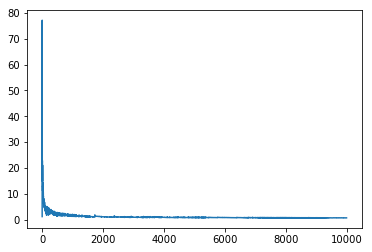

In [103]:
training_losses = train_network(1,num_steps, state_size)
plt.plot(training_losses)